In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import statistics

In [2]:
# iters 300'000, batch 64, seq length 300, initial sequence 1, hidden dim 512, n layers 4, nx 5, nu 1, ny 1
with open('rnn_one_step.npy', 'rb') as f:
    rnn_one_step = np.load(f)

# iters 200'000, batch 64, seq length 300, initial sequence 1, hidden dim 512, n layers 4, nx 5, nu 1, ny 1
with open('lstm_one_step.npy', 'rb') as f:
    lstm_one_step = np.load(f)
    
# iters 200'000, batch 64, seq length 600, initial sequence 1, hidden dim 512, n layers 4, nx 10, nu 1, ny 1
with open('lstm_wh_one_step.npy', 'rb') as f:
    lstm_wh_one_step = np.load(f)

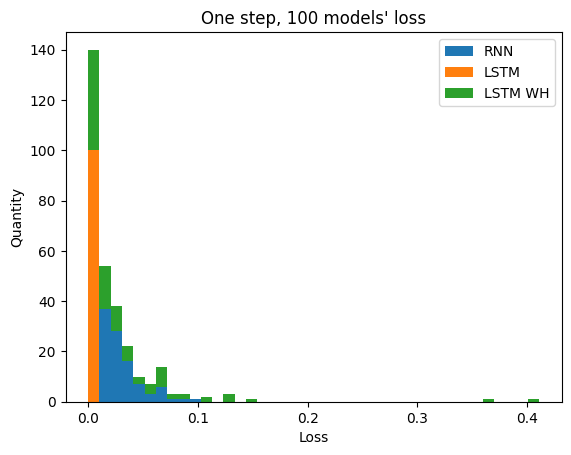

In [3]:
labels = ['RNN', 'LSTM', 'LSTM WH']
plt.title('One step, 100 models\' loss')
plt.xlabel("Loss")
plt.ylabel("Quantity")
plt.hist([rnn_one_step, lstm_one_step, lstm_wh_one_step], 40, label=labels, stacked=True)
plt.legend(prop={'size': 10})
plt.show()

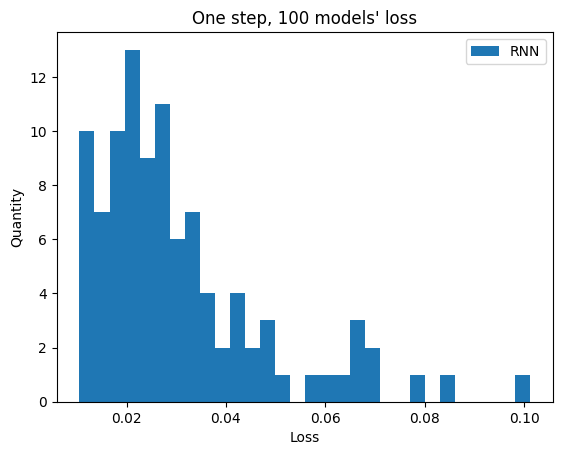

In [4]:
labels = ['RNN']
plt.title('One step, 100 models\' loss')
plt.xlabel("Loss")
plt.ylabel("Quantity")
plt.hist(rnn_one_step, 30, label=labels)
plt.legend(prop={'size': 10})
plt.show()

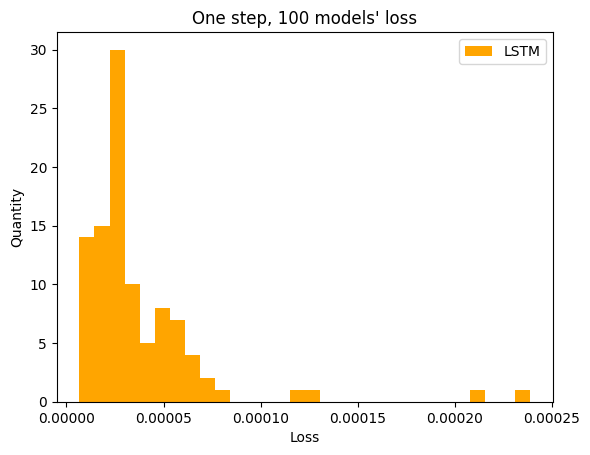

In [5]:
labels = ['LSTM']
plt.title('One step, 100 models\' loss')
plt.xlabel("Loss")
plt.ylabel("Quantity")
plt.hist(lstm_one_step, 30, label=labels, color='orange')
plt.legend(prop={'size': 10})
plt.show()

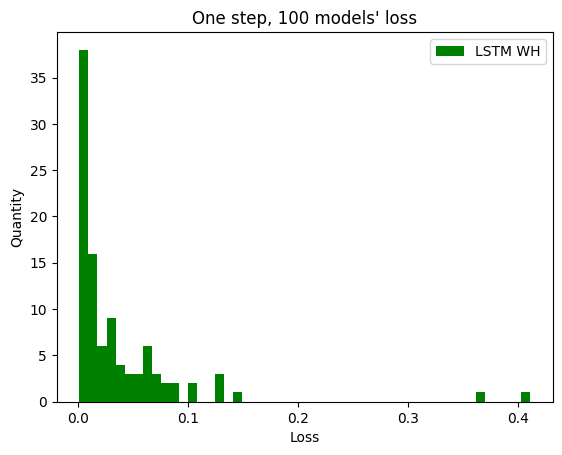

In [6]:
labels = ['LSTM WH']
plt.title('One step, 100 models\' loss')
plt.xlabel("Loss")
plt.ylabel("Quantity")
plt.hist(lstm_wh_one_step, 50, label=labels, color='green')
plt.legend(prop={'size': 10})
plt.show()

In [7]:
# iters 300'000, batch 64, seq length 300, initial sequence 50, hidden dim 512, n layers 4, nx 5, nu 1, ny 1
with open('simulation_rnn.npy', 'rb') as f:
    simulation_rnn = np.load(f)

# iters 200'000, batch 64, seq length 300, initial sequence 50, hidden dim 512, n layers 4, nx 5, nu 1, ny 1
with open('simulation_lstm.npy', 'rb') as f:
    simulation_lstm = np.load(f)

# iters 100'000, batch 64, seq length 300, initial sequence 50, hidden dim 512, n layers 4, nx 10, nu 2, ny 1
with open('simulation_lstm_2_nu.npy', 'rb') as f:
    simulation_lstm_2_nu = np.load(f)

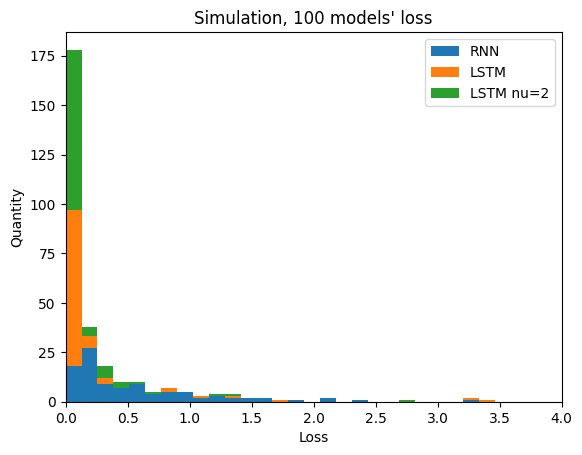

In [8]:
labels = ['RNN', 'LSTM', 'LSTM nu=2']
plt.title('Simulation, 100 models\' loss')
plt.xlabel("Loss")
plt.ylabel("Quantity")
plt.xlim([0, 4])
plt.hist([simulation_rnn, simulation_lstm, simulation_lstm_2_nu], 100, label=labels, stacked=True)
plt.legend(prop={'size': 10})
plt.show()

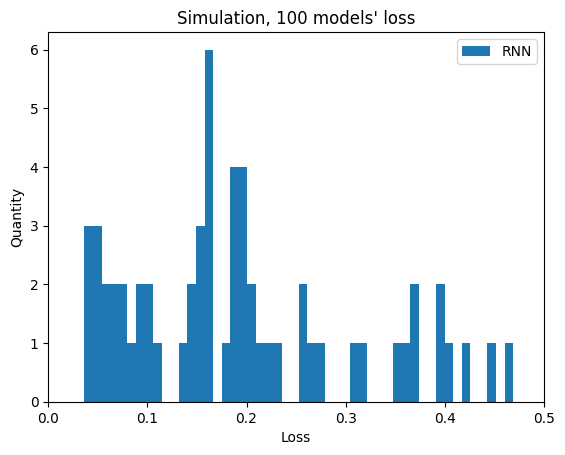

In [9]:
labels = ['RNN']
plt.title('Simulation, 100 models\' loss')
plt.xlabel("Loss")
plt.ylabel("Quantity")
plt.xlim([0, 0.5])
plt.hist(simulation_rnn[simulation_rnn <= 0.5], 50, label=labels)
plt.legend(prop={'size': 10})
plt.show()

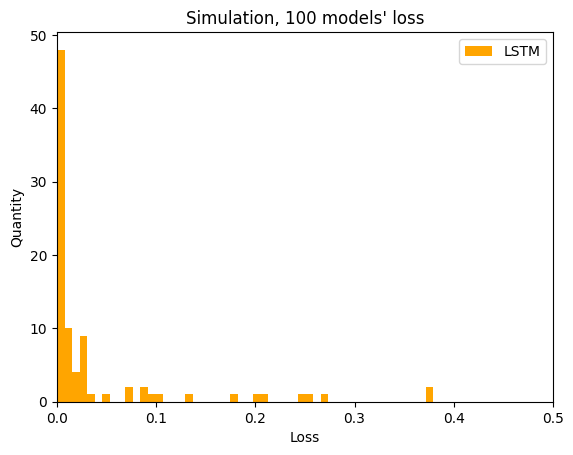

In [10]:
labels = ['LSTM']
plt.title('Simulation, 100 models\' loss')
plt.xlabel("Loss")
plt.ylabel("Quantity")
plt.xlim([0, 0.5])
plt.hist(simulation_lstm[simulation_lstm <= 0.5], 50, label=labels, color='orange')
plt.legend(prop={'size': 10})
plt.show()

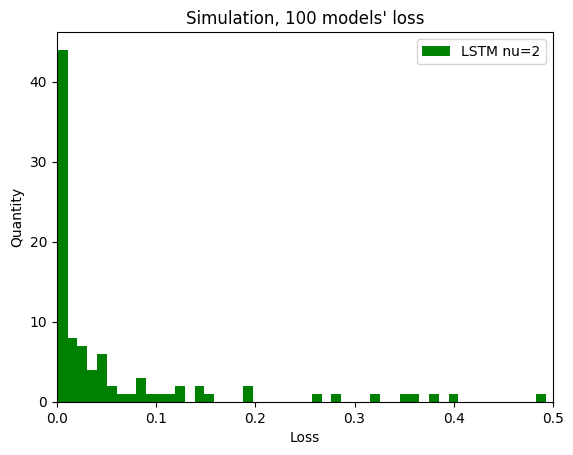

In [11]:
labels = ['LSTM nu=2']
plt.title('Simulation, 100 models\' loss')
plt.xlabel("Loss")
plt.ylabel("Quantity")
plt.xlim([0, 0.5])
plt.hist(simulation_lstm_2_nu[simulation_lstm_2_nu <= 0.5], 50, label=labels, color='green')
plt.legend(prop={'size': 10})
plt.show()

In [12]:
import sys
# setting path
sys.path.append('../')

import torch
import math
from torch import nn
from dataset import LinearDynamicalDataset, WHDataset
from torch.utils.data import DataLoader
from lstm_model import LSTModel
from rnn_model import RNNModel

In [13]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device('cuda')
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [14]:
nx = 10
nu = 2
ny = 1

model_lstm_2nu = LSTModel(input_size=nu + ny, output_size=ny, hidden_dim=512, n_layers=4)
model_lstm_2nu.load_state_dict(torch.load('../trained_models/nu_2_lstm_model100000', map_location=device))
model_lstm_2nu.eval()

nx = 5
nu = 1
ny = 1

model_rnn = RNNModel(input_size=nu + ny, output_size=ny, hidden_dim=512, n_layers=4)
model_rnn.load_state_dict(torch.load('../trained_models/rnn_model300000', map_location=device))
model_rnn.eval()

model_lstm = LSTModel(input_size=nu + ny, output_size=ny, hidden_dim=512, n_layers=4)
model_lstm.load_state_dict(torch.load('../trained_models/lstm_model200000', map_location=device))
model_lstm.eval()

criterion = nn.MSELoss()

In [15]:
def evaluate(batch_u, batch_y, model, initial_sequence, one_step):
    with torch.no_grad():
        seq_length = batch_u.shape[1]
        n_u = batch_u.shape[2]
        n_y = batch_y.shape[2]
        
        input_seq = batch_u

        start_zero = torch.zeros([1, 1, n_y])
        input_y = batch_y[:, 0:init_sequence, :]
        input_y = torch.cat((start_zero, input_y), dim=1)
        zeros = torch.zeros([1,seq_length - init_sequence - 1, n_y])
        input_y = torch.cat((input_y, zeros), dim=1)

        input_seq = torch.cat((input_seq, input_y), dim=2)

        total_loss = 0
        for i in range(init_sequence, seq_length):
            seq = input_seq[:, 0:i+1, :]
            output, hidden = model(seq)
            loss = criterion(output[0][-1][0], batch_y[0][i][0])
            total_loss += loss
            
            if i+1 == seq_length:
                break

            if one_step:
                input_seq[0][i+1][n_u] = batch_y[0][i][0]
            else:
                input_seq[0][i+1][n_u] = output[0][-1][0]

        errors = (batch_y - output).detach().numpy()[0]
        loss = criterion(output, batch_y)
        predictions = output.detach().numpy()[0]

        print("loss without initial sequence:")
        mean_loss = total_loss / (seq_length-init_sequence)
        print(mean_loss.item())
        
        return predictions, errors
    
def plot_input_output(batch_u, batch_y, predictions):
    n_u = batch_u.shape[2]
    fig, ax = plt.subplots(n_u + 1, 1, sharex=True)

    for i in range(n_u):
        ax[i].set_title(f"Input {i+1}")
        ax[i].plot(batch_u[0][:, i], c='blue')
    ax[n_u].set_title("Output")
    ax[n_u].plot(batch_y[0], c='blue')
    ax[n_u].plot(predictions, c='red')

    plt.show()

In [16]:
test_ds = LinearDynamicalDataset(nx=5, nu=1, ny=1, seq_len=300)
test_dl = DataLoader(test_ds, batch_size=1, num_workers=0)
init_sequence = 1
one_step = True
batch_y, batch_u = next(iter(test_dl))

In [17]:
predictions_rnn, errors_rnn = evaluate(batch_u, batch_y, model_rnn, init_sequence, one_step)
predictions_lstm, errors_lstm = evaluate(batch_u, batch_y, model_lstm, init_sequence, one_step)

loss without initial sequence:
0.022555390372872353
loss without initial sequence:
0.00024803512496873736


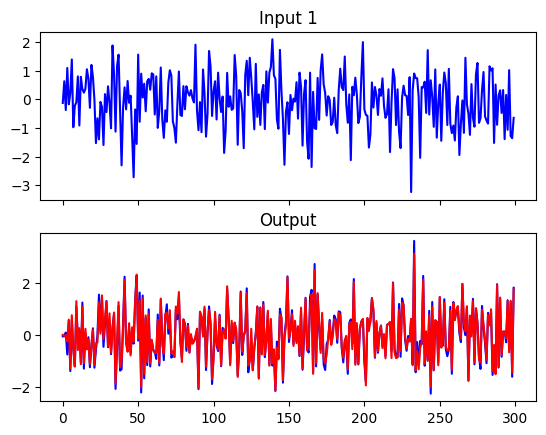

In [18]:
plot_input_output(batch_u, batch_y, predictions_rnn)

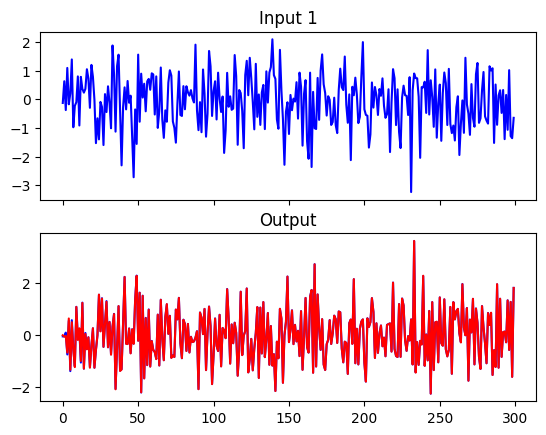

In [19]:
plot_input_output(batch_u, batch_y, predictions_lstm)

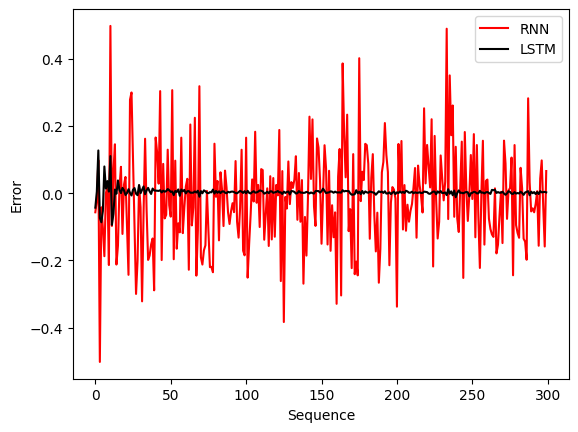

In [20]:
plt.xlabel("Sequence")
plt.ylabel("Error")
plt.plot(errors_rnn.flatten(), label='RNN', c='red')
plt.plot(errors_lstm.flatten(), label='LSTM', c='black')
plt.legend(prop={'size': 10})
plt.show()

loss without initial sequence:
0.0032128903549164534


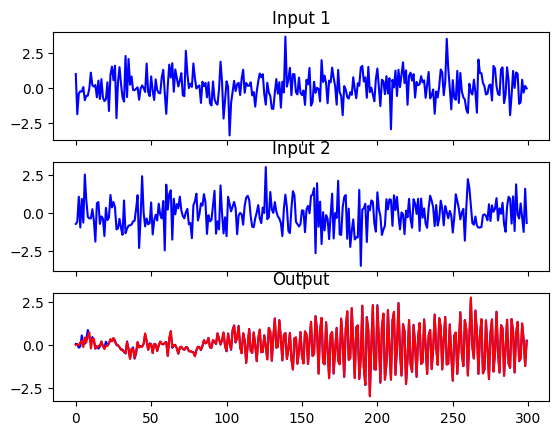

In [21]:
test_ds = LinearDynamicalDataset(nx=10, nu=2, ny=1, seq_len=300)
test_dl = DataLoader(test_ds, batch_size=1, num_workers=0)
init_sequence = 1
one_step = True
batch_y, batch_u = next(iter(test_dl))

predictions_lstm_2nu, errors_lstm_2nu = evaluate(batch_u, batch_y, model_lstm_2nu, init_sequence, one_step)

plot_input_output(batch_u, batch_y, predictions_lstm_2nu)

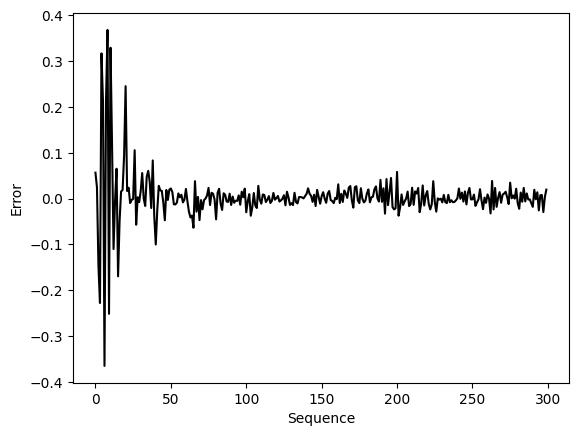

In [22]:
plt.xlabel("Sequence")
plt.ylabel("Error")
plt.plot(errors_lstm_2nu.flatten(), c='black')
plt.show()

loss without initial sequence:
0.9252963662147522


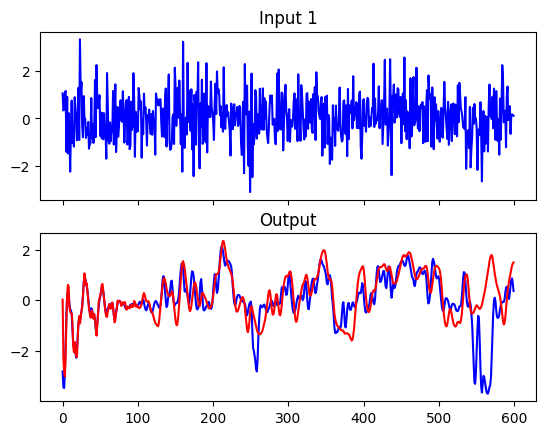

In [27]:
model_wh = LSTModel(input_size=2, output_size=1, hidden_dim=512, n_layers=4)
model_wh.load_state_dict(torch.load('../trained_models/wh_lstm_model200000', map_location=device))

test_ds = WHDataset(nx=5, nu=1, ny=1, seq_len=600, mag_range=(0.5, 0.97), phase_range=(0, math.pi/2))
test_dl = DataLoader(test_ds, batch_size=1, num_workers=0)

init_sequence = 100
one_step = False
batch_y, batch_u = next(iter(test_dl))

predictions_wh, errors_wh = evaluate(batch_u, batch_y, model_wh, init_sequence, one_step)

plot_input_output(batch_u, batch_y, predictions_wh)

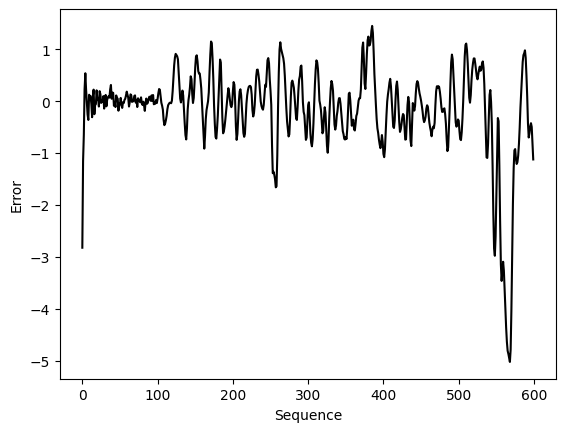

In [28]:
plt.xlabel("Sequence")
plt.ylabel("Error")
plt.plot(errors_wh.flatten(), c='black')
plt.show()